In [1]:
import glob
import sys
import warnings
import joblib
import xrft
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from AutoML import AutomatedRegression

In [2]:
# importing from one directory  up
sys.path.insert(0, "../" )
from misc import prediction_ML

# - Load data

In [17]:
data_dir = "/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/"
data_type = "4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200.nc"
scenarios = glob.glob(f"{data_dir}*{data_type}")

In [19]:
#  Dropping Aghulas scenarios for now
scenarios = [x for x in scenarios if not 'Aghulas' in x]
scenarios_train = [x for x in scenarios if 'Azores' not in x and 'Scotland' not in x]
scenarios_test = [x for x in scenarios if 'Azores'  in x or 'Scotland' in x]
scenarios_train, scenarios_test

(['/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Barbedos_20201110_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200.nc',
  '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Carrib_20231104_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200.nc',
  '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Iceland_20231107_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200.nc',
  '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Morroco_20201103_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200.nc',
  '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Hawaii_20201106_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200.nc'],
 ['/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Azores_20201127_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200.nc',
  '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Sc

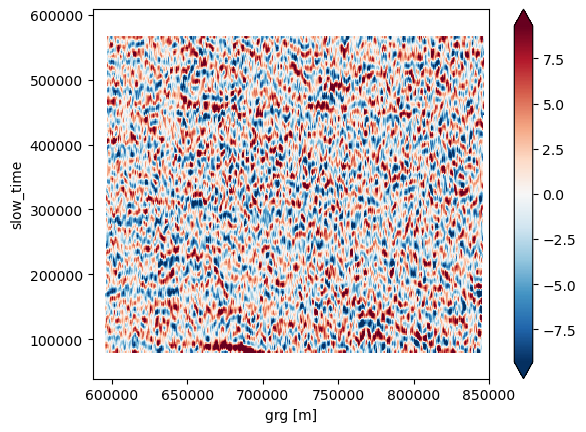

In [36]:
y_data_avg.T.plot(robust = True)

In [47]:
n = 20 # number of azimuth cells to consider from center (e.g. total azimuth cells is 2*n +1)
spacing_slow_time = 2*n # pixels
spacing_ground_range = 2*n # pixels
N_avg_grg = 30 # data is averaged over N pixels along ground range
N_avg_st = 3 # data is averaged over N pixels along slow_time

# --------------Training--------------
X_train = []
y_train = []
for scenario in scenarios_train:
    data = xr.open_dataset(scenario)

    # slow time can not be indexed for concatonation step, remove indexing if present
    try:
        data = data.reset_index('slow_time')
    except:
        pass

    x_data_avg = data.nrcs_scat_w_noise.rolling(grg=N_avg_grg, slow_time=N_avg_st, center=True).mean()
    y_data_avg = (data.V_leakage_pulse_rg - data.V_leakage_pulse_rg_inverted).rolling(grg=N_avg_grg, slow_time=N_avg_st, center=True).mean()

    X_data = xr.concat([x_data_avg.isel(slow_time=slice(i-n, 1+i+n)).drop_vars('slow_time') for i in range(n, data.sizes['slow_time']-n)], dim='placeholder')
    y_data = xr.concat([y_data_avg.isel(slow_time=i) for i in range(n, data.sizes['slow_time']-n)], dim='placeholder')

    # Training
    X_train_spaced = X_data.isel(placeholder=slice(None,None, spacing_slow_time), grg=slice(None,None, spacing_ground_range)).values.reshape(-1, 2*n+1)
    y_train_spaced = y_data.isel(placeholder=slice(None,None, spacing_slow_time), grg=slice(None,None, spacing_ground_range)).values.reshape(-1)

    data_train = pd.DataFrame(np.column_stack((X_train_spaced,y_train_spaced))).dropna()
    X_train.append(data_train.iloc[:,:-1])
    y_train.append(data_train.iloc[:,-1])

X_train = pd.concat(X_train)
y_train = pd.concat(y_train)


# --------------Testing--------------
X_test = []
y_test = []
for scenario in scenarios_test:
    data = xr.open_dataset(scenario)
    
    # slow time can not be indexed for concatonation step, remove indexing if present
    try:
        data = data.reset_index('slow_time')
    except:
        pass
    
    x_data_avg = data.nrcs_scat_w_noise.rolling(grg=N_avg_grg, slow_time=N_avg_st, center=True).mean()
    y_data_avg = (data.V_leakage_pulse_rg - data.V_leakage_pulse_rg_inverted).rolling(grg=N_avg_grg, slow_time=N_avg_st, center=True).mean()

    X_data = xr.concat([x_data_avg.isel(slow_time=slice(i-n, 1+i+n)).drop_vars('slow_time') for i in range(n, data.sizes['slow_time']-n)], dim='placeholder')
    y_data = xr.concat([y_data_avg.isel(slow_time=i) for i in range(n, data.sizes['slow_time']-n)], dim='placeholder')

    X_test_pre = X_data.values.reshape(-1, 2*n+1)
    y_test_pre = y_data.values.reshape(-1)

    data_test = pd.DataFrame(np.column_stack((X_test_pre,y_test_pre))).dropna()
    X_test.append(data_test.iloc[:,:-1])
    y_test.append(data_test.iloc[:,-1])
                  

In [13]:
def warning_catcher(function, *args):
    with warnings.catch_warnings(record=True) as caught_warnings:
        output_buffer = io.StringIO()
        stdout_save = sys.stdout
        sys.stdout = output_buffer

        try:
            function(*args)
        except Exception as e:
            sys.stdout = stdout_save
            print(e)
        
        sys.stdout = stdout_save

    return 

def warning_catcher2(function, *args):
    with warnings.catch_warnings(record=True) as caught_warnings:
        output_buffer = io.StringIO()
        stdout_save = sys.stdout
        sys.stdout = output_buffer

        try:
            result = function(*args)
        except Exception as e:
            sys.stdout = stdout_save
            print(e)
        
        sys.stdout = stdout_save

    return result

In [57]:
# Instantiate model and overwrite automated Train / Test split
from sklearn.metrics import median_absolute_error, r2_score

ML = AutomatedRegression(
    X=X_train,           # NOTE these are overwritten 
    y=X_train,           # NOTE these are overwritten 
    timeout=1200, # seconds
    n_trial=100,
    metric_optimise = median_absolute_error, # r2_score
    optimisation_direction='minimize',
    models_to_optimize=['catboost', 'lightgbm', 'xgboost'],
    models_to_assess=['bayesianridge','catboost', 'lightgbm', 'xgboost'],
    n_jobs=6,
    # n_weak_models=4,
    reload_study=False,
    reload_trial_cap=True,
    write_folder='/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/ML_analyses/Vleak_2by2km_w_noise_n_20_5Tr_2Te_v1/',
)

ML.X_test = X_test[0]
ML.X_train = X_train
ML.y_test = y_test[0]
ML.y_train = y_train 


warning_catcher(ML.apply)
# ML.apply()
ML.summary

/Users/opodriscoll/Documents/Scripts/DopSCA/src/automl/AutoML/automl.py:236: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_numeric_columns = (~self.X.applymap(np.isreal).any(axis = 0))
[I 2024-01-24 11:45:51,020] A new study created in RDB with name: regression_catboost
CatBoost custom logger function is already set in another thread, will use it from this thread. If you are training CatBoost models from different threads, consider using sys.stdout and sys.stderr default loggers
CatBoost custom logger function is already set in another thread, will use it from this thread. If you are training CatBoost models from different threads, consider using sys.stdout and sys.stderr default loggers
CatBoost custom logger function is already set in another thread, will use it from this thread. If you are training CatBoost models from different threads, consider using sys.stdout and sys.stderr default loggers
CatBoost custom logger function is already set i

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=8.877562938173316, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.877562938173316
[LightGBM] [Warning] feature_fraction is set=0.9294142735192285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9294142735192285
[LightGBM] [Warning] bagging_fraction is set=0.8810177696702741, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8810177696702741
[LightGBM] [Warning] lambda_l2 is set=0.002236020033478595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002236020033478595
[LightGBM] [Warning] lambda_l1 is set=2.7294403964239744e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7294403964239744e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=4.8733

[I 2024-01-24 11:48:41,255] Trial 0 finished with value: 1.699017641272882 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 17, 'n_estimators': 84, 'max_bin': 1023, 'min_gain_to_split': 8.877562938173316, 'lambda_l1': 2.7294403964239744e-06, 'lambda_l2': 0.002236020033478595, 'num_leaves': 131, 'feature_fraction': 0.9294142735192285, 'bagging_fraction': 0.8810177696702741, 'bagging_freq': 5, 'min_child_samples': 42, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 0 with value: 1.699017641272882.
[I 2024-01-24 11:48:41,392] Trial 5 finished with value: 1.7378776167570558 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 3, 'n_estimators': 50, 'max_bin': 127, 'min_gain_to_split': 6.982852791427399, 'lambda_l1': 0.001296297665730772, 'lambda_l2': 0.011996399418160669, 'num_leaves': 198, 'feature_fraction': 0.6866782690527543, 'bagging_fraction': 0.48161915970771635, 'bagging_freq': 6, 'min_child_samples':

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=6.982852791427399, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.982852791427399
[LightGBM] [Warning] feature_fraction is set=0.6866782690527543, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6866782690527543
[LightGBM] [Warning] bagging_fraction is set=0.48161915970771635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48161915970771635
[LightGBM] [Warning] lambda_l2 is set=0.011996399418160669, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011996399418160669
[LightGBM] [Warning] lambda_l1 is set=0.001296297665730772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001296297665730772
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=13.19255

[I 2024-01-24 11:48:45,190] Trial 2 pruned. 


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=1.279384505361934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.279384505361934
[LightGBM] [Warning] feature_fraction is set=0.886794145770063, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.886794145770063
[LightGBM] [Warning] bagging_fraction is set=0.7920881294808705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7920881294808705
[LightGBM] [Warning] lambda_l2 is set=5.176251505003179, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.176251505003179
[LightGBM] [Warning] lambda_l1 is set=0.469392176443521, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.469392176443521
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=9.388548354920857, min_s

[I 2024-01-24 11:48:52,965] Trial 1 pruned. 


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=13.192556367786805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.192556367786805
[LightGBM] [Warning] feature_fraction is set=0.7809682346091437, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7809682346091437
[LightGBM] [Warning] bagging_fraction is set=0.4248011562596162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4248011562596162
[LightGBM] [Warning] lambda_l2 is set=6.014542936865732e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.014542936865732e-06
[LightGBM] [Warning] lambda_l1 is set=0.17370373382708185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17370373382708185
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=3.508037

[I 2024-01-24 11:48:56,506] Trial 8 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=3.138030867453957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.138030867453957
[LightGBM] [Warning] feature_fraction is set=0.706832809668459, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.706832809668459
[LightGBM] [Warning] bagging_fraction is set=0.7753823206026397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7753823206026397
[LightGBM] [Warning] lambda_l2 is set=1.0292024512529434e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0292024512529434e-05
[LightGBM] [Warning] lambda_l1 is set=2.1797256513015766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1797256513015766
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=3.5080370110

[I 2024-01-24 11:48:57,974] Trial 3 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=3.138030867453957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.138030867453957
[LightGBM] [Warning] feature_fraction is set=0.706832809668459, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.706832809668459
[LightGBM] [Warning] bagging_fraction is set=0.7753823206026397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7753823206026397
[LightGBM] [Warning] lambda_l2 is set=1.0292024512529434e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0292024512529434e-05
[LightGBM] [Warning] lambda_l1 is set=2.1797256513015766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1797256513015766
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=12.793288041

[I 2024-01-24 11:49:04,067] Trial 9 pruned. 


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=4.594800268414551, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.594800268414551
[LightGBM] [Warning] feature_fraction is set=0.6109671087246294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6109671087246294
[LightGBM] [Warning] bagging_fraction is set=0.31795037467734155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.31795037467734155
[LightGBM] [Warning] lambda_l2 is set=0.00011883078355105463, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011883078355105463
[LightGBM] [Warning] lambda_l1 is set=1.6086025635993498e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6086025635993498e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=

[I 2024-01-24 11:49:11,212] Trial 6 pruned. 


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.049898605298967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.049898605298967
[LightGBM] [Warning] feature_fraction is set=0.6093477542440466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6093477542440466
[LightGBM] [Warning] bagging_fraction is set=0.5836864161041234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5836864161041234
[LightGBM] [Warning] lambda_l2 is set=0.0009975962881889516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009975962881889516
[LightGBM] [Warning] lambda_l1 is set=0.0019888604064322944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0019888604064322944
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=12.750

[I 2024-01-24 11:49:11,675] Trial 11 finished with value: 1.7816994051212398 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 6, 'n_estimators': 118, 'max_bin': 63, 'min_gain_to_split': 12.793288041223267, 'lambda_l1': 1.1926112661861821e-05, 'lambda_l2': 4.468592000913504e-06, 'num_leaves': 141, 'feature_fraction': 0.45311943923444403, 'bagging_fraction': 0.9050356808360742, 'bagging_freq': 2, 'min_child_samples': 59, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 0 with value: 1.699017641272882.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=5.304636845006743, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.304636845006743
[LightGBM] [Warning] feature_fraction is set=0.9936281424617717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9936281424617717
[LightGBM] [Warning] bagging_fraction is set=0.4837703776928121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4837703776928121
[LightGBM] [Warning] lambda_l2 is set=0.0020667017960390344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0020667017960390344
[LightGBM] [Warning] lambda_l1 is set=7.844712199612737e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.844712199612737e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.0498

[I 2024-01-24 11:49:13,834] Trial 4 finished with value: 1.6442713472083466 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 9, 'n_estimators': 310, 'max_bin': 63, 'min_gain_to_split': 4.873384721912563, 'lambda_l1': 1.6333140653321183, 'lambda_l2': 0.00037037959743921637, 'num_leaves': 82, 'feature_fraction': 0.5114298166875909, 'bagging_fraction': 0.8472891144298483, 'bagging_freq': 2, 'min_child_samples': 80, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 4 with value: 1.6442713472083466.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=4.594800268414551, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.594800268414551
[LightGBM] [Warning] feature_fraction is set=0.6109671087246294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6109671087246294
[LightGBM] [Warning] bagging_fraction is set=0.31795037467734155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.31795037467734155
[LightGBM] [Warning] lambda_l2 is set=0.00011883078355105463, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011883078355105463
[LightGBM] [Warning] lambda_l1 is set=1.6086025635993498e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6086025635993498e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=

[I 2024-01-24 11:49:16,554] Trial 7 finished with value: 1.7729635970678401 and parameters: {'scaler': None, 'objective': 'regression', 'max_depth': 8, 'n_estimators': 633, 'max_bin': 63, 'min_gain_to_split': 12.75078295849303, 'lambda_l1': 0.41025915046411043, 'lambda_l2': 0.014808511793758864, 'num_leaves': 124, 'feature_fraction': 0.8345694983495257, 'bagging_fraction': 0.23383063657875666, 'bagging_freq': 5, 'min_child_samples': 2, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 4 with value: 1.6442713472083466.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.049898605298967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.049898605298967
[LightGBM] [Warning] feature_fraction is set=0.6093477542440466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6093477542440466
[LightGBM] [Warning] bagging_fraction is set=0.5836864161041234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5836864161041234
[LightGBM] [Warning] lambda_l2 is set=0.0009975962881889516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009975962881889516
[LightGBM] [Warning] lambda_l1 is set=0.0019888604064322944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0019888604064322944
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=14.373

[I 2024-01-24 11:49:23,755] Trial 10 finished with value: 1.6692636967526624 and parameters: {'scaler': None, 'objective': 'regression', 'max_depth': 10, 'n_estimators': 116, 'max_bin': 63, 'min_gain_to_split': 3.138030867453957, 'lambda_l1': 2.1797256513015766, 'lambda_l2': 1.0292024512529434e-05, 'num_leaves': 252, 'feature_fraction': 0.706832809668459, 'bagging_fraction': 0.7753823206026397, 'bagging_freq': 5, 'min_child_samples': 71, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 4 with value: 1.6442713472083466.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=14.37324351108575, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.37324351108575
[LightGBM] [Warning] feature_fraction is set=0.40107542429385074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40107542429385074
[LightGBM] [Warning] bagging_fraction is set=0.33657411385481506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.33657411385481506
[LightGBM] [Warning] lambda_l2 is set=6.524682320979064e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.524682320979064e-08
[LightGBM] [Warning] lambda_l1 is set=0.17967211102294048, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17967211102294048
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=7.1203

[I 2024-01-24 11:49:27,941] Trial 13 pruned. 


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=14.37324351108575, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.37324351108575
[LightGBM] [Warning] feature_fraction is set=0.40107542429385074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40107542429385074
[LightGBM] [Warning] bagging_fraction is set=0.33657411385481506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.33657411385481506
[LightGBM] [Warning] lambda_l2 is set=6.524682320979064e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.524682320979064e-08
[LightGBM] [Warning] lambda_l1 is set=0.17967211102294048, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17967211102294048
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=0.6633

[I 2024-01-24 11:49:38,834] Trial 16 finished with value: 1.6919292824606422 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 17, 'n_estimators': 370, 'max_bin': 1023, 'min_gain_to_split': 14.37324351108575, 'lambda_l1': 0.17967211102294048, 'lambda_l2': 6.524682320979064e-08, 'num_leaves': 196, 'feature_fraction': 0.40107542429385074, 'bagging_fraction': 0.33657411385481506, 'bagging_freq': 7, 'min_child_samples': 17, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 4 with value: 1.6442713472083466.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=0.8831150587485848, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8831150587485848
[LightGBM] [Warning] feature_fraction is set=0.21832498103012923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21832498103012923
[LightGBM] [Warning] bagging_fraction is set=0.6126854277120147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6126854277120147
[LightGBM] [Warning] lambda_l2 is set=0.005453924518779694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005453924518779694
[LightGBM] [Warning] lambda_l1 is set=3.039121384711489e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.039121384711489e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=5.30

[I 2024-01-24 11:49:41,548] Trial 17 finished with value: 1.6815500128442487 and parameters: {'scaler': None, 'objective': 'regression', 'max_depth': 18, 'n_estimators': 88, 'max_bin': 127, 'min_gain_to_split': 7.120325613408085, 'lambda_l1': 1.0422396171312615e-05, 'lambda_l2': 0.005463275825701173, 'num_leaves': 153, 'feature_fraction': 0.5160235751982469, 'bagging_fraction': 0.31113605381543613, 'bagging_freq': 5, 'min_child_samples': 31, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 4 with value: 1.6442713472083466.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=5.304636845006743, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.304636845006743
[LightGBM] [Warning] feature_fraction is set=0.9936281424617717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9936281424617717
[LightGBM] [Warning] bagging_fraction is set=0.4837703776928121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4837703776928121
[LightGBM] [Warning] lambda_l2 is set=0.0020667017960390344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0020667017960390344
[LightGBM] [Warning] lambda_l1 is set=7.844712199612737e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.844712199612737e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.5252

[I 2024-01-24 11:49:45,360] Trial 14 pruned. 


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.005220957881489241, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005220957881489241
[LightGBM] [Warning] feature_fraction is set=0.5073280626661215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5073280626661215
[LightGBM] [Warning] bagging_fraction is set=0.7011962206374772, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7011962206374772
[LightGBM] [Warning] lambda_l2 is set=1.6664205872627122e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6664205872627122e-08
[LightGBM] [Warning] lambda_l1 is set=8.382209977795506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.382209977795506
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=4.5948

[I 2024-01-24 11:49:47,833] Trial 20 pruned. 


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=4.594800268414551, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.594800268414551
[LightGBM] [Warning] feature_fraction is set=0.6109671087246294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6109671087246294
[LightGBM] [Warning] bagging_fraction is set=0.31795037467734155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.31795037467734155
[LightGBM] [Warning] lambda_l2 is set=0.00011883078355105463, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011883078355105463
[LightGBM] [Warning] lambda_l1 is set=1.6086025635993498e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6086025635993498e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=

[I 2024-01-24 11:49:54,656] Trial 21 pruned. 
[I 2024-01-24 11:49:54,738] Trial 15 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=4.656986807834917, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.656986807834917
[LightGBM] [Warning] feature_fraction is set=0.6148398920199478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6148398920199478
[LightGBM] [Warning] bagging_fraction is set=0.12138993214427163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12138993214427163
[LightGBM] [Warning] lambda_l2 is set=1.2645127971463657e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2645127971463657e-05
[LightGBM] [Warning] lambda_l1 is set=4.3931306699969495e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.3931306699969495e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=

[I 2024-01-24 11:49:59,746] Trial 23 pruned. 


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=4.594800268414551, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.594800268414551
[LightGBM] [Warning] feature_fraction is set=0.6109671087246294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6109671087246294
[LightGBM] [Warning] bagging_fraction is set=0.31795037467734155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.31795037467734155
[LightGBM] [Warning] lambda_l2 is set=0.00011883078355105463, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011883078355105463
[LightGBM] [Warning] lambda_l1 is set=1.6086025635993498e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6086025635993498e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=

[I 2024-01-24 11:50:01,300] Trial 22 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=4.048965324119216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.048965324119216
[LightGBM] [Warning] feature_fraction is set=0.9976554918737164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9976554918737164
[LightGBM] [Warning] bagging_fraction is set=0.6777941536973024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6777941536973024
[LightGBM] [Warning] lambda_l2 is set=2.5758804493598813e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5758804493598813e-05
[LightGBM] [Warning] lambda_l1 is set=0.012396858253454471, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012396858253454471
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.6108

[I 2024-01-24 11:50:05,708] Trial 12 finished with value: 1.7210195909777568 and parameters: {'scaler': 'robust', 'objective': 'regression', 'max_depth': 12, 'n_estimators': 897, 'max_bin': 511, 'min_gain_to_split': 4.594800268414551, 'lambda_l1': 1.6086025635993498e-07, 'lambda_l2': 0.00011883078355105463, 'num_leaves': 198, 'feature_fraction': 0.6109671087246294, 'bagging_fraction': 0.31795037467734155, 'bagging_freq': 7, 'min_child_samples': 61, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 4 with value: 1.6442713472083466.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.6108660528057428, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6108660528057428
[LightGBM] [Warning] feature_fraction is set=0.30901422160850744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30901422160850744
[LightGBM] [Warning] bagging_fraction is set=0.2523410879305135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2523410879305135
[LightGBM] [Warning] lambda_l2 is set=0.0002842656073504078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002842656073504078
[LightGBM] [Warning] lambda_l1 is set=4.9376367360562245e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9376367360562245e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=

[I 2024-01-24 11:50:06,246] Trial 18 finished with value: 1.6751677128521387 and parameters: {'scaler': 'robust', 'objective': 'regression', 'max_depth': 4, 'n_estimators': 371, 'max_bin': 1023, 'min_gain_to_split': 0.6633801970184899, 'lambda_l1': 0.014815262444492543, 'lambda_l2': 6.084964828657767e-05, 'num_leaves': 66, 'feature_fraction': 0.37945073376927246, 'bagging_fraction': 0.32704468839875733, 'bagging_freq': 6, 'min_child_samples': 95, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 4 with value: 1.6442713472083466.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=2.954468695536058, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.954468695536058
[LightGBM] [Warning] feature_fraction is set=0.9697686616053565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9697686616053565
[LightGBM] [Warning] bagging_fraction is set=0.6428788431317184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6428788431317184
[LightGBM] [Warning] lambda_l2 is set=4.5996049085919355e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5996049085919355e-05
[LightGBM] [Warning] lambda_l1 is set=0.011125665739210056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011125665739210056
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=6.4361

[I 2024-01-24 11:50:16,333] Trial 24 finished with value: 1.7414363041731846 and parameters: {'scaler': None, 'objective': 'regression', 'max_depth': 14, 'n_estimators': 117, 'max_bin': 511, 'min_gain_to_split': 4.048965324119216, 'lambda_l1': 0.012396858253454471, 'lambda_l2': 2.5758804493598813e-05, 'num_leaves': 180, 'feature_fraction': 0.9976554918737164, 'bagging_fraction': 0.6777941536973024, 'bagging_freq': 5, 'min_child_samples': 97, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 4 with value: 1.6442713472083466.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=1.5604136369233994, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5604136369233994
[LightGBM] [Warning] feature_fraction is set=0.926986571072488, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.926986571072488
[LightGBM] [Warning] bagging_fraction is set=0.6603949867290675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6603949867290675
[LightGBM] [Warning] lambda_l2 is set=2.1090441281896033e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1090441281896033e-06
[LightGBM] [Warning] lambda_l1 is set=9.761015101209635e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.761015101209635e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=3.78

[I 2024-01-24 11:50:18,032] Trial 27 pruned. 


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=2.2599057969921423, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2599057969921423
[LightGBM] [Warning] feature_fraction is set=0.3771573154972351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3771573154972351
[LightGBM] [Warning] bagging_fraction is set=0.8145861250309966, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8145861250309966
[LightGBM] [Warning] lambda_l2 is set=9.504861386598958e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.504861386598958e-07
[LightGBM] [Warning] lambda_l1 is set=1.1334114751503082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1334114751503082
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=2.95446869

[I 2024-01-24 11:50:20,842] Trial 25 pruned. 


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=1.5604136369233994, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5604136369233994
[LightGBM] [Warning] feature_fraction is set=0.926986571072488, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.926986571072488
[LightGBM] [Warning] bagging_fraction is set=0.6603949867290675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6603949867290675
[LightGBM] [Warning] lambda_l2 is set=2.1090441281896033e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1090441281896033e-06
[LightGBM] [Warning] lambda_l1 is set=9.761015101209635e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.761015101209635e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=8.57

[I 2024-01-24 11:50:25,027] Trial 31 pruned. 


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=2.3284029122336865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3284029122336865
[LightGBM] [Warning] feature_fraction is set=0.42542169671582597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42542169671582597
[LightGBM] [Warning] bagging_fraction is set=0.8045403655439707, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8045403655439707
[LightGBM] [Warning] lambda_l2 is set=5.309709997569471e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.309709997569471e-07
[LightGBM] [Warning] lambda_l1 is set=1.060777810753736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.060777810753736
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=2.25990579

[I 2024-01-24 11:50:29,279] Trial 30 pruned. 


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=6.640791843627755, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.640791843627755
[LightGBM] [Warning] feature_fraction is set=0.638528716485218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.638528716485218
[LightGBM] [Warning] bagging_fraction is set=0.9684542273990686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9684542273990686
[LightGBM] [Warning] lambda_l2 is set=0.014636545268693561, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.014636545268693561
[LightGBM] [Warning] lambda_l1 is set=0.005204814119064357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005204814119064357
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=2.3284029122

[I 2024-01-24 11:50:39,628] Trial 28 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=0.005773169204116191, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005773169204116191
[LightGBM] [Warning] feature_fraction is set=0.14867104699049116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14867104699049116
[LightGBM] [Warning] bagging_fraction is set=0.8567427289095464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8567427289095464
[LightGBM] [Warning] lambda_l2 is set=1.8827155653444898, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8827155653444898
[LightGBM] [Warning] lambda_l1 is set=0.018342680483351057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.018342680483351057
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=1.5604

[I 2024-01-24 11:50:43,502] Trial 33 pruned. 


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=2.3284029122336865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3284029122336865
[LightGBM] [Warning] feature_fraction is set=0.42542169671582597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42542169671582597
[LightGBM] [Warning] bagging_fraction is set=0.8045403655439707, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8045403655439707
[LightGBM] [Warning] lambda_l2 is set=5.309709997569471e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.309709997569471e-07
[LightGBM] [Warning] lambda_l1 is set=1.060777810753736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.060777810753736
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=0.49210458

[I 2024-01-24 11:50:50,916] Trial 26 finished with value: 1.6985248513006055 and parameters: {'scaler': 'robust', 'objective': 'regression', 'max_depth': 3, 'n_estimators': 399, 'max_bin': 511, 'min_gain_to_split': 1.6108660528057428, 'lambda_l1': 4.9376367360562245e-08, 'lambda_l2': 0.0002842656073504078, 'num_leaves': 131, 'feature_fraction': 0.30901422160850744, 'bagging_fraction': 0.2523410879305135, 'bagging_freq': 1, 'min_child_samples': 61, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 4 with value: 1.6442713472083466.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=0.4921045857064434, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4921045857064434
[LightGBM] [Warning] feature_fraction is set=0.12655533482494885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12655533482494885
[LightGBM] [Warning] bagging_fraction is set=0.8078425902770283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8078425902770283
[LightGBM] [Warning] lambda_l2 is set=7.492071277565562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.492071277565562
[LightGBM] [Warning] lambda_l1 is set=0.015482590036629785, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015482590036629785
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=5.3602216069

[I 2024-01-24 11:50:52,372] Trial 32 pruned. 


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=5.360221606909198, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.360221606909198
[LightGBM] [Warning] feature_fraction is set=0.5997701624036322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5997701624036322
[LightGBM] [Warning] bagging_fraction is set=0.7883879341778778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7883879341778778
[LightGBM] [Warning] lambda_l2 is set=5.865154874098574e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.865154874098574e-07
[LightGBM] [Warning] lambda_l1 is set=0.09684808936269859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09684808936269859
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=0.21066345

[I 2024-01-24 11:50:57,623] Trial 36 pruned. 


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=0.8831150587485848, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8831150587485848
[LightGBM] [Warning] feature_fraction is set=0.21832498103012923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21832498103012923
[LightGBM] [Warning] bagging_fraction is set=0.6126854277120147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6126854277120147
[LightGBM] [Warning] lambda_l2 is set=0.005453924518779694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005453924518779694
[LightGBM] [Warning] lambda_l1 is set=3.039121384711489e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.039121384711489e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=0.13

[I 2024-01-24 11:51:01,027] Trial 29 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=0.13210660565164878, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.13210660565164878
[LightGBM] [Warning] feature_fraction is set=0.22789425072042283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22789425072042283
[LightGBM] [Warning] bagging_fraction is set=0.7951095844056039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7951095844056039
[LightGBM] [Warning] lambda_l2 is set=1.4282337519162542, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4282337519162542
[LightGBM] [Warning] lambda_l1 is set=0.00029125242062457703, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00029125242062457703
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=0.54

[I 2024-01-24 11:51:08,342] Trial 38 finished with value: 1.6604579140375442 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 20, 'n_estimators': 55, 'max_bin': 127, 'min_gain_to_split': 0.13210660565164878, 'lambda_l1': 0.00029125242062457703, 'lambda_l2': 1.4282337519162542, 'num_leaves': 58, 'feature_fraction': 0.22789425072042283, 'bagging_fraction': 0.7951095844056039, 'bagging_freq': 5, 'min_child_samples': 93, 'random_state': 42, 'verbosity': -1, 'transformers': 'quantile_trans', 'n_quantiles': 300}. Best is trial 4 with value: 1.6442713472083466.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=0.9555945909846146, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9555945909846146
[LightGBM] [Warning] feature_fraction is set=0.1227416357303433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1227416357303433
[LightGBM] [Warning] bagging_fraction is set=0.8814858466266458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8814858466266458
[LightGBM] [Warning] lambda_l2 is set=2.1730780438551762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1730780438551762
[LightGBM] [Warning] lambda_l1 is set=0.00015276150587052305, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00015276150587052305
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=0.492104

[I 2024-01-24 11:51:17,740] Trial 19 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=0.5475551181717178, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5475551181717178
[LightGBM] [Warning] feature_fraction is set=0.11307698446598369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11307698446598369
[LightGBM] [Warning] bagging_fraction is set=0.9130557496277726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9130557496277726
[LightGBM] [Warning] lambda_l2 is set=2.571717773988704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.571717773988704
[LightGBM] [Warning] lambda_l1 is set=8.615807564789845e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.615807564789845e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=8.33578356

[I 2024-01-24 11:51:24,989] Trial 41 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=0.5475551181717178, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5475551181717178
[LightGBM] [Warning] feature_fraction is set=0.11307698446598369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11307698446598369
[LightGBM] [Warning] bagging_fraction is set=0.9130557496277726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9130557496277726
[LightGBM] [Warning] lambda_l2 is set=2.571717773988704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.571717773988704
[LightGBM] [Warning] lambda_l1 is set=8.615807564789845e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.615807564789845e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=0.21066345

[I 2024-01-24 11:51:42,605] Trial 42 finished with value: 1.7574902376991957 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 3, 'n_estimators': 203, 'max_bin': 1023, 'min_gain_to_split': 0.2013260177222635, 'lambda_l1': 0.0004068747019632981, 'lambda_l2': 8.848746597387226, 'num_leaves': 33, 'feature_fraction': 0.1054051989017028, 'bagging_fraction': 0.8542820170370296, 'bagging_freq': 4, 'min_child_samples': 99, 'random_state': 42, 'verbosity': -1, 'transformers': 'quantile_trans', 'n_quantiles': 100}. Best is trial 4 with value: 1.6442713472083466.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=0.9555945909846146, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9555945909846146
[LightGBM] [Warning] feature_fraction is set=0.1227416357303433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1227416357303433
[LightGBM] [Warning] bagging_fraction is set=0.8814858466266458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8814858466266458
[LightGBM] [Warning] lambda_l2 is set=2.1730780438551762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1730780438551762
[LightGBM] [Warning] lambda_l1 is set=0.00015276150587052305, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00015276150587052305
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=8.246585

[I 2024-01-24 11:51:46,563] Trial 43 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=3.216416097743961, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.216416097743961
[LightGBM] [Warning] feature_fraction is set=0.10132269714473344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10132269714473344
[LightGBM] [Warning] bagging_fraction is set=0.8525038696353091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8525038696353091
[LightGBM] [Warning] lambda_l2 is set=1.996664355802968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.996664355802968
[LightGBM] [Warning] lambda_l1 is set=0.03170387041351219, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03170387041351219
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=0.95559459098461

[I 2024-01-24 11:51:54,080] Trial 44 pruned. 


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=3.4685607853886338, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4685607853886338
[LightGBM] [Warning] feature_fraction is set=0.3692162028039261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3692162028039261
[LightGBM] [Warning] bagging_fraction is set=0.9970460485365811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9970460485365811
[LightGBM] [Warning] lambda_l2 is set=0.14937526485012048, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14937526485012048
[LightGBM] [Warning] lambda_l1 is set=6.453639107229028, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.453639107229028
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=3.46856078538863

[I 2024-01-24 11:51:56,563] Trial 45 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=10.20722607166125, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.20722607166125
[LightGBM] [Warning] feature_fraction is set=0.894800400956917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.894800400956917
[LightGBM] [Warning] bagging_fraction is set=0.9830826879206568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9830826879206568
[LightGBM] [Warning] lambda_l2 is set=0.000200746653313623, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000200746653313623
[LightGBM] [Warning] lambda_l1 is set=7.848504377310469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.848504377310469
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=10.20722607166125,

[I 2024-01-24 11:52:07,285] Trial 46 finished with value: 1.6562674307745155 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 18, 'n_estimators': 80, 'max_bin': 1023, 'min_gain_to_split': 10.20722607166125, 'lambda_l1': 7.848504377310469, 'lambda_l2': 0.000200746653313623, 'num_leaves': 256, 'feature_fraction': 0.894800400956917, 'bagging_fraction': 0.9830826879206568, 'bagging_freq': 5, 'min_child_samples': 68, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 4 with value: 1.6442713472083466.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=0.08484528149158521, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08484528149158521
[LightGBM] [Warning] feature_fraction is set=0.18537359979610918, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18537359979610918
[LightGBM] [Warning] bagging_fraction is set=0.45703538118116455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45703538118116455
[LightGBM] [Warning] lambda_l2 is set=0.13412467266435496, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13412467266435496
[LightGBM] [Warning] lambda_l1 is set=0.00016063053873184216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016063053873184216
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=

[I 2024-01-24 11:52:16,447] Trial 35 finished with value: 1.7650586717603207 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 4, 'n_estimators': 1681, 'max_bin': 1023, 'min_gain_to_split': 0.4921045857064434, 'lambda_l1': 0.015482590036629785, 'lambda_l2': 7.492071277565562, 'num_leaves': 27, 'feature_fraction': 0.12655533482494885, 'bagging_fraction': 0.8078425902770283, 'bagging_freq': 5, 'min_child_samples': 93, 'random_state': 42, 'verbosity': -1, 'transformers': 'quantile_trans', 'n_quantiles': 100}. Best is trial 4 with value: 1.6442713472083466.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=2.7852748642886245, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7852748642886245
[LightGBM] [Warning] feature_fraction is set=0.23519120485676137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23519120485676137
[LightGBM] [Warning] bagging_fraction is set=0.4344263468281287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4344263468281287
[LightGBM] [Warning] lambda_l2 is set=0.14164458235345131, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14164458235345131
[LightGBM] [Warning] lambda_l1 is set=0.00024955825796038535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024955825796038535
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=2.78

[I 2024-01-24 11:52:28,409] Trial 48 pruned. 


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=10.507788944169869, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.507788944169869
[LightGBM] [Warning] feature_fraction is set=0.8305528879054781, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8305528879054781
[LightGBM] [Warning] bagging_fraction is set=0.9758922591489896, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9758922591489896
[LightGBM] [Warning] lambda_l2 is set=0.00018988077326925648, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018988077326925648
[LightGBM] [Warning] lambda_l1 is set=2.61104120951068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.61104120951068
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=10.507788944

[I 2024-01-24 11:52:42,309] Trial 37 finished with value: 1.7533579215029964 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 3, 'n_estimators': 1989, 'max_bin': 127, 'min_gain_to_split': 0.21066345540524706, 'lambda_l1': 0.00011042060617720483, 'lambda_l2': 5.742119529396079, 'num_leaves': 55, 'feature_fraction': 0.17561336737574695, 'bagging_fraction': 0.8657456446020015, 'bagging_freq': 5, 'min_child_samples': 91, 'random_state': 42, 'verbosity': -1, 'transformers': 'quantile_trans', 'n_quantiles': 200}. Best is trial 4 with value: 1.6442713472083466.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=10.507788944169869, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.507788944169869
[LightGBM] [Warning] feature_fraction is set=0.8305528879054781, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8305528879054781
[LightGBM] [Warning] bagging_fraction is set=0.9758922591489896, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9758922591489896
[LightGBM] [Warning] lambda_l2 is set=0.00018988077326925648, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018988077326925648
[LightGBM] [Warning] lambda_l1 is set=2.61104120951068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.61104120951068
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=11.223348431

[I 2024-01-24 11:52:45,158] Trial 49 finished with value: 1.6270604476452166 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 13, 'n_estimators': 170, 'max_bin': 1023, 'min_gain_to_split': 10.507788944169869, 'lambda_l1': 2.61104120951068, 'lambda_l2': 0.00018988077326925648, 'num_leaves': 256, 'feature_fraction': 0.8305528879054781, 'bagging_fraction': 0.9758922591489896, 'bagging_freq': 2, 'min_child_samples': 68, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 49 with value: 1.6270604476452166.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=11.223348431689594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.223348431689594
[LightGBM] [Warning] feature_fraction is set=0.8391776445129864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8391776445129864
[LightGBM] [Warning] bagging_fraction is set=0.985605786011835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.985605786011835
[LightGBM] [Warning] lambda_l2 is set=0.00020436215930041702, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00020436215930041702
[LightGBM] [Warning] lambda_l1 is set=8.705936422424966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.705936422424966
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=10.266637675

[I 2024-01-24 11:52:46,722] Trial 39 finished with value: 1.732672957268327 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 20, 'n_estimators': 1975, 'max_bin': 127, 'min_gain_to_split': 0.5475551181717178, 'lambda_l1': 8.615807564789845e-05, 'lambda_l2': 2.571717773988704, 'num_leaves': 30, 'feature_fraction': 0.11307698446598369, 'bagging_fraction': 0.9130557496277726, 'bagging_freq': 5, 'min_child_samples': 98, 'random_state': 42, 'verbosity': -1, 'transformers': 'quantile_trans', 'n_quantiles': 600}. Best is trial 49 with value: 1.6270604476452166.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=10.266637675078236, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.266637675078236
[LightGBM] [Warning] feature_fraction is set=0.8422858642763295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8422858642763295
[LightGBM] [Warning] bagging_fraction is set=0.9333613618196485, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9333613618196485
[LightGBM] [Warning] lambda_l2 is set=0.00017248469414733137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017248469414733137
[LightGBM] [Warning] lambda_l1 is set=8.787531888023292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.787531888023292
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=11.2233484

[I 2024-01-24 11:52:53,256] Trial 40 finished with value: 1.7452143161221894 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 20, 'n_estimators': 1835, 'max_bin': 1023, 'min_gain_to_split': 0.9555945909846146, 'lambda_l1': 0.00015276150587052305, 'lambda_l2': 2.1730780438551762, 'num_leaves': 22, 'feature_fraction': 0.1227416357303433, 'bagging_fraction': 0.8814858466266458, 'bagging_freq': 4, 'min_child_samples': 99, 'random_state': 42, 'verbosity': -1, 'transformers': 'quantile_trans', 'n_quantiles': 200}. Best is trial 49 with value: 1.6270604476452166.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=4.33082920296656, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.33082920296656
[LightGBM] [Warning] feature_fraction is set=0.3085795711958132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3085795711958132
[LightGBM] [Warning] bagging_fraction is set=0.7268328866548097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7268328866548097
[LightGBM] [Warning] lambda_l2 is set=0.028761776797002776, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.028761776797002776
[LightGBM] [Warning] lambda_l1 is set=0.0007837171163758028, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007837171163758028
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=4.23954701

[I 2024-01-24 11:52:55,664] Trial 52 pruned. 


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=10.266637675078236, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.266637675078236
[LightGBM] [Warning] feature_fraction is set=0.8422858642763295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8422858642763295
[LightGBM] [Warning] bagging_fraction is set=0.9333613618196485, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9333613618196485
[LightGBM] [Warning] lambda_l2 is set=0.00017248469414733137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017248469414733137
[LightGBM] [Warning] lambda_l1 is set=8.787531888023292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.787531888023292
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=4.23954701

[I 2024-01-24 11:52:56,820] Trial 50 finished with value: 1.7192548117535587 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 12, 'n_estimators': 161, 'max_bin': 1023, 'min_gain_to_split': 11.223348431689594, 'lambda_l1': 8.705936422424966, 'lambda_l2': 0.00020436215930041702, 'num_leaves': 252, 'feature_fraction': 0.8391776445129864, 'bagging_fraction': 0.985605786011835, 'bagging_freq': 2, 'min_child_samples': 68, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 49 with value: 1.6270604476452166.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=10.592765413193728, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.592765413193728
[LightGBM] [Warning] feature_fraction is set=0.8177881348594735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8177881348594735
[LightGBM] [Warning] bagging_fraction is set=0.991078834357611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.991078834357611
[LightGBM] [Warning] lambda_l2 is set=0.00014945675694546777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014945675694546777
[LightGBM] [Warning] lambda_l1 is set=9.702575629837783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.702575629837783
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=10.353723965

[I 2024-01-24 11:52:57,295] Trial 34 pruned. 


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=10.266637675078236, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.266637675078236
[LightGBM] [Warning] feature_fraction is set=0.8422858642763295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8422858642763295
[LightGBM] [Warning] bagging_fraction is set=0.9333613618196485, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9333613618196485
[LightGBM] [Warning] lambda_l2 is set=0.00017248469414733137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017248469414733137
[LightGBM] [Warning] lambda_l1 is set=8.787531888023292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.787531888023292
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=10.3537239

[I 2024-01-24 11:52:58,960] Trial 55 pruned. 


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=7.5365714695346355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.5365714695346355
[LightGBM] [Warning] feature_fraction is set=0.7943415795729557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7943415795729557
[LightGBM] [Warning] bagging_fraction is set=0.8569819519619066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8569819519619066
[LightGBM] [Warning] lambda_l2 is set=0.0006057288330263006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006057288330263006
[LightGBM] [Warning] lambda_l1 is set=0.060050218711998726, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.060050218711998726
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=9.9436

[I 2024-01-24 11:52:59,564] Trial 56 pruned. 


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=7.5365714695346355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.5365714695346355
[LightGBM] [Warning] feature_fraction is set=0.7943415795729557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7943415795729557
[LightGBM] [Warning] bagging_fraction is set=0.8569819519619066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8569819519619066
[LightGBM] [Warning] lambda_l2 is set=0.0006057288330263006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006057288330263006
[LightGBM] [Warning] lambda_l1 is set=0.060050218711998726, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.060050218711998726
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=14.515

[I 2024-01-24 11:53:00,889] Trial 51 finished with value: 1.6802151531166438 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 18, 'n_estimators': 163, 'max_bin': 1023, 'min_gain_to_split': 10.266637675078236, 'lambda_l1': 8.787531888023292, 'lambda_l2': 0.00017248469414733137, 'num_leaves': 222, 'feature_fraction': 0.8422858642763295, 'bagging_fraction': 0.9333613618196485, 'bagging_freq': 2, 'min_child_samples': 64, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 49 with value: 1.6270604476452166.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=10.592765413193728, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.592765413193728
[LightGBM] [Warning] feature_fraction is set=0.8177881348594735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8177881348594735
[LightGBM] [Warning] bagging_fraction is set=0.991078834357611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.991078834357611
[LightGBM] [Warning] lambda_l2 is set=0.00014945675694546777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014945675694546777
[LightGBM] [Warning] lambda_l1 is set=9.702575629837783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.702575629837783
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=7.5365714695

[I 2024-01-24 11:53:03,476] Trial 53 pruned. 
[I 2024-01-24 11:53:03,547] Trial 57 pruned. 


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=2.4858613205662254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4858613205662254
[LightGBM] [Warning] feature_fraction is set=0.4075172903441663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4075172903441663
[LightGBM] [Warning] bagging_fraction is set=0.4852146465986735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4852146465986735
[LightGBM] [Warning] lambda_l2 is set=5.437577638450846e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.437577638450846e-05
[LightGBM] [Warning] lambda_l1 is set=2.895897924288758e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.895897924288758e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=14.5

[I 2024-01-24 11:53:04,514] Trial 58 pruned. 


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=0.08484528149158521, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08484528149158521
[LightGBM] [Warning] feature_fraction is set=0.18537359979610918, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18537359979610918
[LightGBM] [Warning] bagging_fraction is set=0.45703538118116455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45703538118116455
[LightGBM] [Warning] lambda_l2 is set=0.13412467266435496, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13412467266435496
[LightGBM] [Warning] lambda_l1 is set=0.00016063053873184216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016063053873184216
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=

[I 2024-01-24 11:53:09,529] Trial 54 finished with value: 1.7073101624283709 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 18, 'n_estimators': 145, 'max_bin': 1023, 'min_gain_to_split': 10.592765413193728, 'lambda_l1': 9.702575629837783, 'lambda_l2': 0.00014945675694546777, 'num_leaves': 223, 'feature_fraction': 0.8177881348594735, 'bagging_fraction': 0.991078834357611, 'bagging_freq': 2, 'min_child_samples': 64, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 49 with value: 1.6270604476452166.
[I 2024-01-24 11:53:09,584] Trial 60 pruned. 


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=11.071543025470922, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.071543025470922
[LightGBM] [Warning] feature_fraction is set=0.7382227055864503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7382227055864503
[LightGBM] [Warning] bagging_fraction is set=0.9145361398759347, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9145361398759347
[LightGBM] [Warning] lambda_l2 is set=0.003612808321368695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003612808321368695
[LightGBM] [Warning] lambda_l1 is set=1.4236116455394625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4236116455394625
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=2.2113972901

[I 2024-01-24 11:53:10,208] Trial 62 pruned. 


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=9.026490509143644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.026490509143644
[LightGBM] [Warning] feature_fraction is set=0.7434658718335011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7434658718335011
[LightGBM] [Warning] bagging_fraction is set=0.9234918590451754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9234918590451754
[LightGBM] [Warning] lambda_l2 is set=0.0006302225659635544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006302225659635544
[LightGBM] [Warning] lambda_l1 is set=1.9230031806181713, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9230031806181713
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=9.2559819655

[I 2024-01-24 11:53:11,473] Trial 59 pruned. 


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=9.026490509143644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.026490509143644
[LightGBM] [Warning] feature_fraction is set=0.7434658718335011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7434658718335011
[LightGBM] [Warning] bagging_fraction is set=0.9234918590451754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9234918590451754
[LightGBM] [Warning] lambda_l2 is set=0.0006302225659635544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006302225659635544
[LightGBM] [Warning] lambda_l1 is set=1.9230031806181713, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9230031806181713
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=0.0848452814

[I 2024-01-24 11:53:12,024] Trial 63 pruned. 


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=9.026490509143644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.026490509143644
[LightGBM] [Warning] feature_fraction is set=0.7434658718335011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7434658718335011
[LightGBM] [Warning] bagging_fraction is set=0.9234918590451754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9234918590451754
[LightGBM] [Warning] lambda_l2 is set=0.0006302225659635544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006302225659635544
[LightGBM] [Warning] lambda_l1 is set=1.9230031806181713, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9230031806181713
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=2.2264551190

[I 2024-01-24 11:53:16,196] Trial 64 pruned. 


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=2.226455119035318, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.226455119035318
[LightGBM] [Warning] feature_fraction is set=0.43459466064727975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43459466064727975
[LightGBM] [Warning] bagging_fraction is set=0.47039471119563825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47039471119563825
[LightGBM] [Warning] lambda_l2 is set=4.435557761970588e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.435557761970588e-05
[LightGBM] [Warning] lambda_l1 is set=1.6135905487491943e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6135905487491943e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=

[I 2024-01-24 11:53:18,841] Trial 68 pruned. 


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=6.52088022382629, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.52088022382629
[LightGBM] [Warning] feature_fraction is set=0.6813967089961477, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6813967089961477
[LightGBM] [Warning] bagging_fraction is set=0.8402723043880351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8402723043880351
[LightGBM] [Warning] lambda_l2 is set=0.01545365212343434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01545365212343434
[LightGBM] [Warning] lambda_l1 is set=3.18044826784001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.18044826784001
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=9.497227820222706, min

[I 2024-01-24 11:53:20,243] Trial 61 pruned. 
[I 2024-01-24 11:53:20,465] Trial 69 pruned. 


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=6.52088022382629, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.52088022382629
[LightGBM] [Warning] feature_fraction is set=0.6813967089961477, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6813967089961477
[LightGBM] [Warning] bagging_fraction is set=0.8402723043880351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8402723043880351
[LightGBM] [Warning] lambda_l2 is set=0.01545365212343434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01545365212343434
[LightGBM] [Warning] lambda_l1 is set=3.18044826784001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.18044826784001
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=9.497227820222706, min

[I 2024-01-24 11:53:21,598] Trial 66 pruned. 


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=6.468902265573649, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.468902265573649
[LightGBM] [Warning] feature_fraction is set=0.6812258031840677, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6812258031840677
[LightGBM] [Warning] bagging_fraction is set=0.8619879427943951, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8619879427943951
[LightGBM] [Warning] lambda_l2 is set=0.0004348393308312383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004348393308312383
[LightGBM] [Warning] lambda_l1 is set=0.1450747251738846, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1450747251738846
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=3.2050529969

[I 2024-01-24 11:53:21,971] Trial 70 pruned. 
[I 2024-01-24 11:53:22,130] Trial 67 pruned. 


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=8.631320578023551, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.631320578023551
[LightGBM] [Warning] feature_fraction is set=0.2415459582986189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2415459582986189
[LightGBM] [Warning] bagging_fraction is set=0.4101684404699188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4101684404699188
[LightGBM] [Warning] lambda_l2 is set=0.0050370603567285515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0050370603567285515
[LightGBM] [Warning] lambda_l1 is set=8.385653796506901e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.385653796506901e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=3.6997

[I 2024-01-24 11:53:24,526] Trial 65 pruned. 


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=3.205052996924154, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.205052996924154
[LightGBM] [Warning] feature_fraction is set=0.2522127058639564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2522127058639564
[LightGBM] [Warning] bagging_fraction is set=0.39178135148586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39178135148586
[LightGBM] [Warning] lambda_l2 is set=0.0028764175238978414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0028764175238978414
[LightGBM] [Warning] lambda_l1 is set=0.0011595412400910467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011595412400910467
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=10.5915938

[I 2024-01-24 11:53:31,037] Trial 75 pruned. 


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=8.631320578023551, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.631320578023551
[LightGBM] [Warning] feature_fraction is set=0.2415459582986189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2415459582986189
[LightGBM] [Warning] bagging_fraction is set=0.4101684404699188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4101684404699188
[LightGBM] [Warning] lambda_l2 is set=0.0050370603567285515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0050370603567285515
[LightGBM] [Warning] lambda_l1 is set=8.385653796506901e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.385653796506901e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=11.118

[I 2024-01-24 11:53:32,245] Trial 74 pruned. 


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=11.118483045734756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.118483045734756
[LightGBM] [Warning] feature_fraction is set=0.24556474568196496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24556474568196496
[LightGBM] [Warning] bagging_fraction is set=0.14992342310990894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14992342310990894
[LightGBM] [Warning] lambda_l2 is set=0.033442916476630766, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.033442916476630766
[LightGBM] [Warning] lambda_l1 is set=1.0057248095578058e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0057248095578058e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=

[I 2024-01-24 11:53:36,461] Trial 73 pruned. 


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=11.118483045734756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.118483045734756
[LightGBM] [Warning] feature_fraction is set=0.24556474568196496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24556474568196496
[LightGBM] [Warning] bagging_fraction is set=0.14992342310990894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14992342310990894
[LightGBM] [Warning] lambda_l2 is set=0.033442916476630766, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.033442916476630766
[LightGBM] [Warning] lambda_l1 is set=1.0057248095578058e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0057248095578058e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=

[I 2024-01-24 11:53:37,788] Trial 71 finished with value: 1.7066676372018534 and parameters: {'scaler': 'robust', 'objective': 'regression', 'max_depth': 15, 'n_estimators': 117, 'max_bin': 255, 'min_gain_to_split': 8.631320578023551, 'lambda_l1': 8.385653796506901e-07, 'lambda_l2': 0.0050370603567285515, 'num_leaves': 89, 'feature_fraction': 0.2415459582986189, 'bagging_fraction': 0.4101684404699188, 'bagging_freq': 6, 'min_child_samples': 69, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 49 with value: 1.6270604476452166.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=9.4887870784145, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.4887870784145
[LightGBM] [Warning] feature_fraction is set=0.8591084471583785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8591084471583785
[LightGBM] [Warning] bagging_fraction is set=0.9337702754323901, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9337702754323901
[LightGBM] [Warning] lambda_l2 is set=0.00031193544183206237, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00031193544183206237
[LightGBM] [Warning] lambda_l1 is set=4.515138395848055, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.515138395848055
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=14.2699354569539

[I 2024-01-24 11:53:40,471] Trial 76 pruned. 


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=9.4887870784145, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.4887870784145
[LightGBM] [Warning] feature_fraction is set=0.8591084471583785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8591084471583785
[LightGBM] [Warning] bagging_fraction is set=0.9337702754323901, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9337702754323901
[LightGBM] [Warning] lambda_l2 is set=0.00031193544183206237, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00031193544183206237
[LightGBM] [Warning] lambda_l1 is set=4.515138395848055, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.515138395848055
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=14.0692700635439

[I 2024-01-24 11:53:43,781] Trial 78 pruned. 


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=14.269935456953942, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.269935456953942
[LightGBM] [Warning] feature_fraction is set=0.36928253272249734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36928253272249734
[LightGBM] [Warning] bagging_fraction is set=0.34145518481688686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34145518481688686
[LightGBM] [Warning] lambda_l2 is set=3.795729330944929e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.795729330944929e-08
[LightGBM] [Warning] lambda_l1 is set=0.10815997655033029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10815997655033029
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=14.0

[I 2024-01-24 11:53:45,941] Trial 77 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=9.995438994869291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.995438994869291
[LightGBM] [Warning] feature_fraction is set=0.8828603709982867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8828603709982867
[LightGBM] [Warning] bagging_fraction is set=0.9423488758045617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9423488758045617
[LightGBM] [Warning] lambda_l2 is set=7.64521853080521e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.64521853080521e-05
[LightGBM] [Warning] lambda_l1 is set=4.129447120572464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.129447120572464
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=5.64094491599444

[I 2024-01-24 11:53:49,367] Trial 72 finished with value: 1.717168929687076 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 5, 'n_estimators': 199, 'max_bin': 255, 'min_gain_to_split': 3.205052996924154, 'lambda_l1': 0.0011595412400910467, 'lambda_l2': 0.0028764175238978414, 'num_leaves': 85, 'feature_fraction': 0.2522127058639564, 'bagging_fraction': 0.39178135148586, 'bagging_freq': 6, 'min_child_samples': 68, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 49 with value: 1.6270604476452166.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=10.115611180736252, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.115611180736252
[LightGBM] [Warning] feature_fraction is set=0.8305857811265143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8305857811265143
[LightGBM] [Warning] bagging_fraction is set=0.9417617918216908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9417617918216908
[LightGBM] [Warning] lambda_l2 is set=7.284455736588745e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.284455736588745e-05
[LightGBM] [Warning] lambda_l1 is set=3.8592634379984507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8592634379984507
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=5.64094491

[I 2024-01-24 11:53:54,828] Trial 80 finished with value: 1.6405668938393503 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 17, 'n_estimators': 122, 'max_bin': 1023, 'min_gain_to_split': 10.115611180736252, 'lambda_l1': 3.8592634379984507, 'lambda_l2': 7.284455736588745e-05, 'num_leaves': 256, 'feature_fraction': 0.8305857811265143, 'bagging_fraction': 0.9417617918216908, 'bagging_freq': 3, 'min_child_samples': 66, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 49 with value: 1.6270604476452166.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=5.199079365765423, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.199079365765423
[LightGBM] [Warning] feature_fraction is set=0.5424457434095533, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5424457434095533
[LightGBM] [Warning] bagging_fraction is set=0.2828853685229914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2828853685229914
[LightGBM] [Warning] lambda_l2 is set=3.9158725455718745e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9158725455718745e-07
[LightGBM] [Warning] lambda_l1 is set=0.3536632137070262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3536632137070262
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=5.64094491

[I 2024-01-24 11:53:55,921] Trial 47 finished with value: 1.7183417113138026 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 20, 'n_estimators': 1914, 'max_bin': 127, 'min_gain_to_split': 0.08484528149158521, 'lambda_l1': 0.00016063053873184216, 'lambda_l2': 0.13412467266435496, 'num_leaves': 3, 'feature_fraction': 0.18537359979610918, 'bagging_fraction': 0.45703538118116455, 'bagging_freq': 6, 'min_child_samples': 91, 'random_state': 42, 'verbosity': -1, 'transformers': 'quantile_trans', 'n_quantiles': 3600}. Best is trial 49 with value: 1.6270604476452166.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=8.520687371663035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.520687371663035
[LightGBM] [Warning] feature_fraction is set=0.8461327467702703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8461327467702703
[LightGBM] [Warning] bagging_fraction is set=0.941200070239189, subsample=1.0 will be ignored. Current value: bagging_fraction=0.941200070239189
[LightGBM] [Warning] lambda_l2 is set=9.407209854742326e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.407209854742326e-05
[LightGBM] [Warning] lambda_l1 is set=3.690216576950362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.690216576950362
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=14.0692700635439

[I 2024-01-24 11:53:58,058] Trial 81 finished with value: 1.663166061146913 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 20, 'n_estimators': 122, 'max_bin': 1023, 'min_gain_to_split': 9.995438994869291, 'lambda_l1': 4.129447120572464, 'lambda_l2': 7.64521853080521e-05, 'num_leaves': 254, 'feature_fraction': 0.8828603709982867, 'bagging_fraction': 0.9423488758045617, 'bagging_freq': 5, 'min_child_samples': 65, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 49 with value: 1.6270604476452166.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=5.524649446410086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.524649446410086
[LightGBM] [Warning] feature_fraction is set=0.5277699632732692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5277699632732692
[LightGBM] [Warning] bagging_fraction is set=0.26159361619129673, subsample=1.0 will be ignored. Current value: bagging_fraction=0.26159361619129673
[LightGBM] [Warning] lambda_l2 is set=5.545425866128243e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.545425866128243e-08
[LightGBM] [Warning] lambda_l1 is set=0.3517232639415287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3517232639415287
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=8.52068737

[I 2024-01-24 11:54:01,089] Trial 79 finished with value: 1.7321032642665322 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 17, 'n_estimators': 398, 'max_bin': 1023, 'min_gain_to_split': 14.069270063543982, 'lambda_l1': 0.104158030051973, 'lambda_l2': 1.3260949542343484e-08, 'num_leaves': 178, 'feature_fraction': 0.36643151661812196, 'bagging_fraction': 0.2791719235343607, 'bagging_freq': 7, 'min_child_samples': 13, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 49 with value: 1.6270604476452166.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=8.520687371663035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.520687371663035
[LightGBM] [Warning] feature_fraction is set=0.8461327467702703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8461327467702703
[LightGBM] [Warning] bagging_fraction is set=0.941200070239189, subsample=1.0 will be ignored. Current value: bagging_fraction=0.941200070239189
[LightGBM] [Warning] lambda_l2 is set=9.407209854742326e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.407209854742326e-05
[LightGBM] [Warning] lambda_l1 is set=3.690216576950362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.690216576950362
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=5.52464944641008

[I 2024-01-24 11:54:04,410] Trial 83 finished with value: 1.67252925027386 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 18, 'n_estimators': 110, 'max_bin': 1023, 'min_gain_to_split': 8.520687371663035, 'lambda_l1': 3.690216576950362, 'lambda_l2': 9.407209854742326e-05, 'num_leaves': 255, 'feature_fraction': 0.8461327467702703, 'bagging_fraction': 0.941200070239189, 'bagging_freq': 5, 'min_child_samples': 65, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 49 with value: 1.6270604476452166.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=5.524649446410086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.524649446410086
[LightGBM] [Warning] feature_fraction is set=0.5277699632732692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5277699632732692
[LightGBM] [Warning] bagging_fraction is set=0.26159361619129673, subsample=1.0 will be ignored. Current value: bagging_fraction=0.26159361619129673
[LightGBM] [Warning] lambda_l2 is set=5.545425866128243e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.545425866128243e-08
[LightGBM] [Warning] lambda_l1 is set=0.3517232639415287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3517232639415287
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=5.64094491

[I 2024-01-24 11:54:07,691] Trial 88 pruned. 


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=5.828836605751432, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.828836605751432
[LightGBM] [Warning] feature_fraction is set=0.5360614332152046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5360614332152046
[LightGBM] [Warning] bagging_fraction is set=0.21614993561986348, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21614993561986348
[LightGBM] [Warning] lambda_l2 is set=0.00121089100262148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00121089100262148
[LightGBM] [Warning] lambda_l1 is set=0.0068675687239308034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0068675687239308034
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=5.523275

[I 2024-01-24 11:54:12,008] Trial 82 pruned. 


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=5.828836605751432, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.828836605751432
[LightGBM] [Warning] feature_fraction is set=0.5360614332152046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5360614332152046
[LightGBM] [Warning] bagging_fraction is set=0.21614993561986348, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21614993561986348
[LightGBM] [Warning] lambda_l2 is set=0.00121089100262148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00121089100262148
[LightGBM] [Warning] lambda_l1 is set=0.0068675687239308034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0068675687239308034
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=5.580072

[I 2024-01-24 11:54:20,541] Trial 86 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=12.491652177562711, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.491652177562711
[LightGBM] [Warning] feature_fraction is set=0.6098558836350314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6098558836350314
[LightGBM] [Warning] bagging_fraction is set=0.21224845468634201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21224845468634201
[LightGBM] [Warning] lambda_l2 is set=0.0014576100748911803, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014576100748911803
[LightGBM] [Warning] lambda_l1 is set=0.0036021775222779724, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0036021775222779724
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=12

[I 2024-01-24 11:54:27,049] Trial 84 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=12.491652177562711, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.491652177562711
[LightGBM] [Warning] feature_fraction is set=0.6098558836350314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6098558836350314
[LightGBM] [Warning] bagging_fraction is set=0.21224845468634201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21224845468634201
[LightGBM] [Warning] lambda_l2 is set=0.0014576100748911803, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014576100748911803
[LightGBM] [Warning] lambda_l1 is set=0.0036021775222779724, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0036021775222779724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.

[I 2024-01-24 11:54:31,120] Trial 91 pruned. 


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4697948840971558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4697948840971558
[LightGBM] [Warning] feature_fraction is set=0.30316614011221316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30316614011221316
[LightGBM] [Warning] bagging_fraction is set=0.21069788809822718, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21069788809822718
[LightGBM] [Warning] lambda_l2 is set=0.00024973215470455425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024973215470455425
[LightGBM] [Warning] lambda_l1 is set=4.983438750471473e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.983438750471473e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is se

[I 2024-01-24 11:54:34,885] Trial 93 pruned. 


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=5.828836605751432, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.828836605751432
[LightGBM] [Warning] feature_fraction is set=0.5360614332152046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5360614332152046
[LightGBM] [Warning] bagging_fraction is set=0.21614993561986348, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21614993561986348
[LightGBM] [Warning] lambda_l2 is set=0.00121089100262148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00121089100262148
[LightGBM] [Warning] lambda_l1 is set=0.0068675687239308034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0068675687239308034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.469794

[I 2024-01-24 11:54:36,635] Trial 89 pruned. 


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=12.360071962000536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.360071962000536
[LightGBM] [Warning] feature_fraction is set=0.8767926813972782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8767926813972782
[LightGBM] [Warning] bagging_fraction is set=0.9991455334683831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9991455334683831
[LightGBM] [Warning] lambda_l2 is set=5.550858244976464e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.550858244976464e-05
[LightGBM] [Warning] lambda_l1 is set=3.980598174088342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.980598174088342
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=6.8116186267

[I 2024-01-24 11:54:47,645] Trial 85 finished with value: 1.7175776442861135 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 17, 'n_estimators': 798, 'max_bin': 1023, 'min_gain_to_split': 5.580072947122445, 'lambda_l1': 0.151163419791235, 'lambda_l2': 1.4354352862010384e-08, 'num_leaves': 188, 'feature_fraction': 0.5231508683417636, 'bagging_fraction': 0.2595964105550056, 'bagging_freq': 7, 'min_child_samples': 44, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 49 with value: 1.6270604476452166.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=8.861993011392634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.861993011392634
[LightGBM] [Warning] feature_fraction is set=0.8834218388459567, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8834218388459567
[LightGBM] [Warning] bagging_fraction is set=0.9997082828121236, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997082828121236
[LightGBM] [Warning] lambda_l2 is set=5.4559096942917185e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.4559096942917185e-05
[LightGBM] [Warning] lambda_l1 is set=3.9609750057695323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9609750057695323
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=8.86199301

[I 2024-01-24 11:54:48,168] Trial 87 finished with value: 1.7767444390069609 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 10, 'n_estimators': 680, 'max_bin': 1023, 'min_gain_to_split': 5.523275884681646, 'lambda_l1': 0.3189087679606206, 'lambda_l2': 0.0006877987687991589, 'num_leaves': 231, 'feature_fraction': 0.5243416164932425, 'bagging_fraction': 0.2089977259723404, 'bagging_freq': 7, 'min_child_samples': 44, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 49 with value: 1.6270604476452166.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=8.861993011392634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.861993011392634
[LightGBM] [Warning] feature_fraction is set=0.8834218388459567, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8834218388459567
[LightGBM] [Warning] bagging_fraction is set=0.9997082828121236, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997082828121236
[LightGBM] [Warning] lambda_l2 is set=5.4559096942917185e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.4559096942917185e-05
[LightGBM] [Warning] lambda_l1 is set=3.9609750057695323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9609750057695323
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=1.29549189

[I 2024-01-24 11:54:48,596] Trial 95 pruned. 


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4697948840971558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4697948840971558
[LightGBM] [Warning] feature_fraction is set=0.30316614011221316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30316614011221316
[LightGBM] [Warning] bagging_fraction is set=0.21069788809822718, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21069788809822718
[LightGBM] [Warning] lambda_l2 is set=0.00024973215470455425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024973215470455425
[LightGBM] [Warning] lambda_l1 is set=4.983438750471473e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.983438750471473e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is se

[I 2024-01-24 11:54:49,382] Trial 96 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=10.78769669915414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.78769669915414
[LightGBM] [Warning] feature_fraction is set=0.8028854849332893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8028854849332893
[LightGBM] [Warning] bagging_fraction is set=0.9462947537919261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9462947537919261
[LightGBM] [Warning] lambda_l2 is set=1.6370435228861957e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6370435228861957e-05
[LightGBM] [Warning] lambda_l1 is set=0.21663060021824201, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21663060021824201
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=12.03456

[I 2024-01-24 11:54:51,825] Trial 98 pruned. 


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=12.034566429001783, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.034566429001783
[LightGBM] [Warning] feature_fraction is set=0.8884324106909023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8884324106909023
[LightGBM] [Warning] bagging_fraction is set=0.9584324227007301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9584324227007301
[LightGBM] [Warning] lambda_l2 is set=4.738326045055509e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.738326045055509e-05
[LightGBM] [Warning] lambda_l1 is set=0.2842130549555724, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2842130549555724
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.46979488

[I 2024-01-24 11:54:54,453] Trial 97 pruned. 


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=1.2954918939020859, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2954918939020859
[LightGBM] [Warning] feature_fraction is set=0.3031166887327052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3031166887327052
[LightGBM] [Warning] bagging_fraction is set=0.361067197426529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.361067197426529
[LightGBM] [Warning] lambda_l2 is set=0.00019217357022215508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019217357022215508
[LightGBM] [Warning] lambda_l1 is set=3.283943730180486e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.283943730180486e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=6.81

[I 2024-01-24 11:54:59,519] Trial 90 finished with value: 1.690160388764245 and parameters: {'scaler': None, 'objective': 'regression', 'max_depth': 10, 'n_estimators': 876, 'max_bin': 511, 'min_gain_to_split': 6.811618626719749, 'lambda_l1': 0.49430570612672514, 'lambda_l2': 0.000737704140042081, 'num_leaves': 229, 'feature_fraction': 0.5800691445347007, 'bagging_fraction': 0.21233459137178068, 'bagging_freq': 7, 'min_child_samples': 48, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 49 with value: 1.6270604476452166.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=1.2954918939020859, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2954918939020859
[LightGBM] [Warning] feature_fraction is set=0.3031166887327052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3031166887327052
[LightGBM] [Warning] bagging_fraction is set=0.361067197426529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.361067197426529
[LightGBM] [Warning] lambda_l2 is set=0.00019217357022215508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019217357022215508
[LightGBM] [Warning] lambda_l1 is set=3.283943730180486e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.283943730180486e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.46

[I 2024-01-24 11:55:02,832] Trial 92 finished with value: 1.6826687207048103 and parameters: {'scaler': 'robust', 'objective': 'regression', 'max_depth': 9, 'n_estimators': 328, 'max_bin': 511, 'min_gain_to_split': 1.4697948840971558, 'lambda_l1': 4.983438750471473e-08, 'lambda_l2': 0.00024973215470455425, 'num_leaves': 105, 'feature_fraction': 0.30316614011221316, 'bagging_fraction': 0.21069788809822718, 'bagging_freq': 1, 'min_child_samples': 58, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 49 with value: 1.6270604476452166.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=1.2954918939020859, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2954918939020859
[LightGBM] [Warning] feature_fraction is set=0.3031166887327052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3031166887327052
[LightGBM] [Warning] bagging_fraction is set=0.361067197426529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.361067197426529
[LightGBM] [Warning] lambda_l2 is set=0.00019217357022215508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019217357022215508
[LightGBM] [Warning] lambda_l1 is set=3.283943730180486e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.283943730180486e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.14

[I 2024-01-24 11:55:06,162] Trial 94 pruned. 


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.1441924303992486, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1441924303992486
[LightGBM] [Warning] feature_fraction is set=0.32870613512497404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.32870613512497404
[LightGBM] [Warning] bagging_fraction is set=0.3581089695269767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3581089695269767
[LightGBM] [Warning] lambda_l2 is set=0.00013853471262003904, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013853471262003904
[LightGBM] [Warning] lambda_l1 is set=2.6328568649608875e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6328568649608875e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is se

[I 2024-01-24 11:55:16,005] Trial 99 finished with value: 1.6890659195072384 and parameters: {'scaler': 'robust', 'objective': 'regression', 'max_depth': 8, 'n_estimators': 505, 'max_bin': 511, 'min_gain_to_split': 1.1441924303992486, 'lambda_l1': 2.6328568649608875e-08, 'lambda_l2': 0.00013853471262003904, 'num_leaves': 141, 'feature_fraction': 0.32870613512497404, 'bagging_fraction': 0.3581089695269767, 'bagging_freq': 1, 'min_child_samples': 82, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 49 with value: 1.6270604476452166.
[I 2024-01-24 11:55:16,049] A new study created in RDB with name: regression_xgboost
[I 2024-01-24 11:55:17,532] Trial 0 finished with value: 1.6877247095108032 and parameters: {'scaler': 'standard', 'booster': 'gblinear', 'lambda': 3.9707639539802373e-05, 'alpha': 1.4382671432392244e-08, 'random_state': 42, 'verbosity': 0, 'transformers': 'quantile_trans', 'n_quantiles': 2600}. Best is trial 0 with value: 1.6877247095108032.
[I 2024-

{'bayesianridge_best': [[1.7321373, 0.005110047],
  [0.035748355759444884, 0.00030624844617562326]],
 'catboost_best': [[1.715038158224186, 0.003386875219652713],
  [0.026322267706858016, 0.0005467745159571004]],
 'lightgbm_best': [[1.7631743497738863, 0.007102555227270815],
  [0.0022591405321219947, 0.001129749183606013]],
 'xgboost_best': [[1.768467, 0.0064487597],
  [-0.004631754696813139, 0.001043921752474999]],
 'stacked': [[1.700947085542733, 0.004783676272805219],
  [0.060305023457206876, 0.00013979137466800425]]}

In [58]:
model = joblib.load('/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/ML_analyses/Vleak_2by2km_w_noise_n_20_5Tr_2Te_v1/stacked_model.joblib')

ML performance, RMSE: 2.583 m/s, median error: -0.332 m/s
Inversion performance, RMSE: 2.666 m/s, median error: 0.085 m/s
ML performance, RMSE: 2.701 m/s, median error: 0.042 m/s
Inversion performance, RMSE: 2.730 m/s, median error: 0.073 m/s


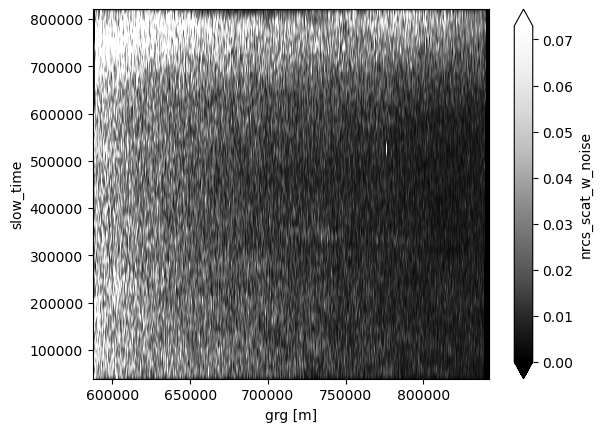

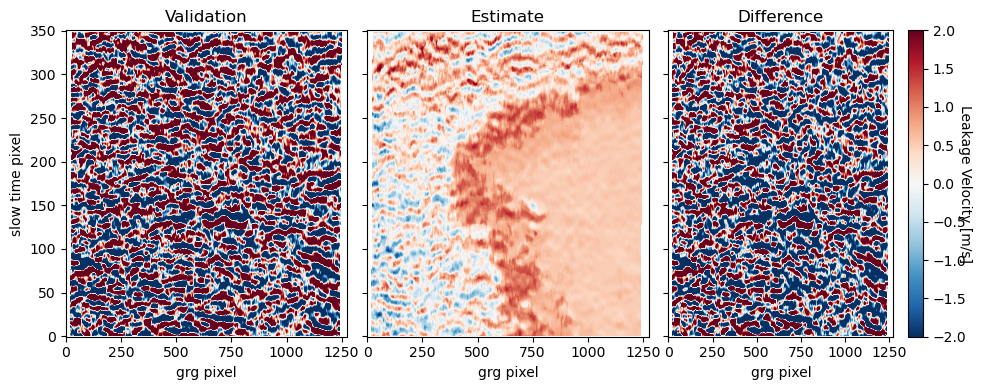

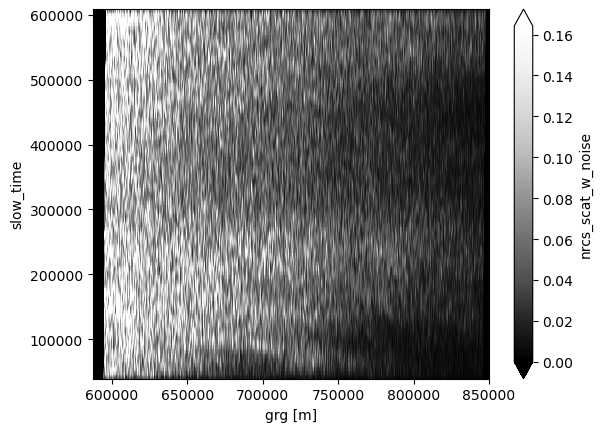

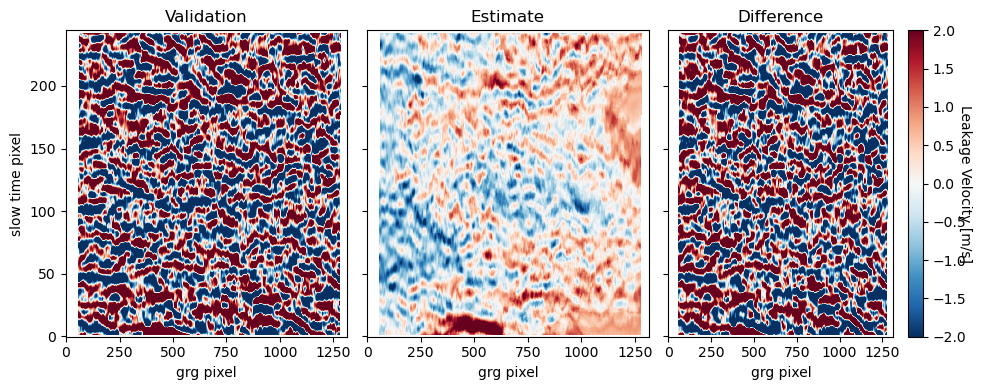

In [59]:
# plot estimation performance per test scenario 

for i, scenario in enumerate(scenarios_test):
    data = xr.open_dataset(scenario)
    plt.figure()
    data.nrcs_scat_w_noise.T.plot(robust =True, vmin =0, cmap = 'Greys_r')
    # scenario_inverse = scenario.replace('4ML_', '4ML_inverse_')
    # data_inverse = xr.open_dataset(scenario_inverse)

    try:
        data = data.reset_index('slow_time')
        # data_inverse = data_inverse.reset_index('slow_time')
    except:
        pass
    
    x_data_avg = data.nrcs_scat_w_noise.rolling(grg=N_avg_grg, slow_time=N_avg_st, center=True).mean()
    y_data_avg = (data.V_leakage_pulse_rg - data.V_leakage_pulse_rg_inverted).rolling(grg=N_avg_grg, slow_time=N_avg_st, center=True).mean()

    X_data = xr.concat([x_data_avg.isel(slow_time=slice(i-n, 1+i+n)).drop_vars('slow_time') for i in range(n, data.sizes['slow_time']-n)], dim='placeholder')
    y_data = xr.concat([y_data_avg.isel(slow_time=i) for i in range(n, data.sizes['slow_time']-n)], dim='placeholder')

    # X_data = xr.concat([data.nrcs_scat_w_noise.isel(slow_time=slice(i-n, 1+i+n)).drop_vars('slow_time')  for i in range(n, len(data.nrcs_scat_w_noise['slow_time'])-n)], dim='placeholder')
    # y = data.V_leakage_pulse_rg_subscene - data.V_leakage_pulse_rg_subscene_inverted
    # y_data = xr.concat([y.isel(slow_time=i) for i in range(n, len(y['slow_time'])-n)], dim='placeholder')


    y_pred = warning_catcher2(model.predict, X_test[i])
    y_shape = y_data.shape

    theoretical_length = y_data.values.reshape(-1).shape
    A = np.nan * np.arange(theoretical_length[0])
    A[y_test[i].index.values] = y_test[i].values
    A = A.reshape(y_shape)

    B = np.nan * np.arange(theoretical_length[0])
    B[y_test[i].index.values] = y_pred
    B = B.reshape(y_shape)

    ds = xr.Dataset(
        data_vars=dict(
            difference = ([ "slow_time", "grg"], A-B),
            original = ([ "slow_time", "grg"], A),
            new = ([ "slow_time", "grg"], B),
    ),
        coords=dict(
            slow_time=(["slow_time"], y_data.slow_time.values),
            grg=(["grg"], y_data.grg.values),
        ),
    )

    # ds = ds.rolling(grg=data.attrs['grg_N'], slow_time=data.attrs['slow_time_N'], center=True).mean()

    perf_ML = np.sqrt(np.nanmean(ds.difference**2)), np.nanmedian(ds.difference)
    perf_inv = np.sqrt(np.nanmean(ds.original**2)), np.nanmedian(ds.original)

    print(f"ML performance, RMSE: {perf_ML[0]:.3f} m/s, median error: {perf_ML[1]:.3f} m/s")
    print(f"Inversion performance, RMSE: {perf_inv[0]:.3f} m/s, median error: {perf_inv[1]:.3f} m/s")



    # ------------- plotting --------------# 
    fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)

    vmin = -2;
    vmax = 2
    im0 = axes[0].imshow(ds.original, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu_r')
    im1 = axes[1].imshow(ds.new, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu_r')
    im2 = axes[2].imshow(ds.difference, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu_r')
    [ax.set_xlabel('grg pixel') for ax in axes]
    axes[0].set_ylabel('slow time pixel')
    axes[0].set_title('Validation')
    axes[1].set_title('Estimate')
    axes[2].set_title('Difference')
    cbar = plt.colorbar(im0, ax=axes[2])
    cbar.ax.set_ylabel('Leakage Velocity [m/s]', rotation=270)
    fig.tight_layout()

ML performance, RMSE: 0.701 m/s, median error: -0.022 m/s
Inversion performance, RMSE: 0.746 m/s, median error: 0.099 m/s
ML performance, RMSE: 0.772 m/s, median error: 0.063 m/s
Inversion performance, RMSE: 0.850 m/s, median error: 0.045 m/s


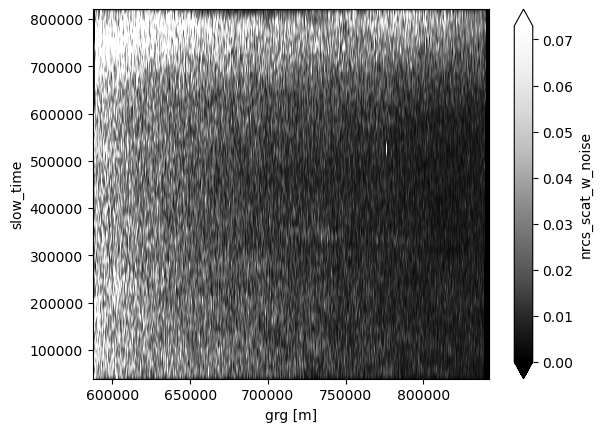

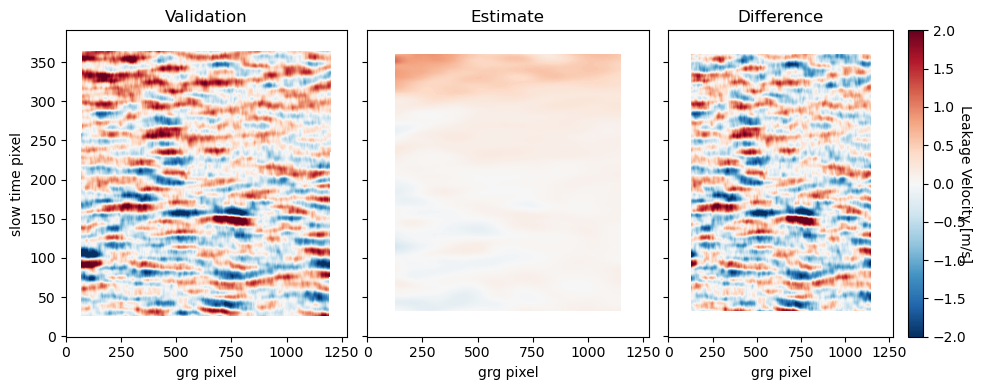

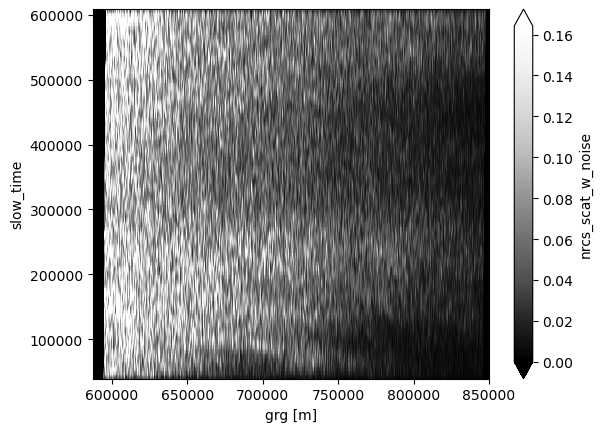

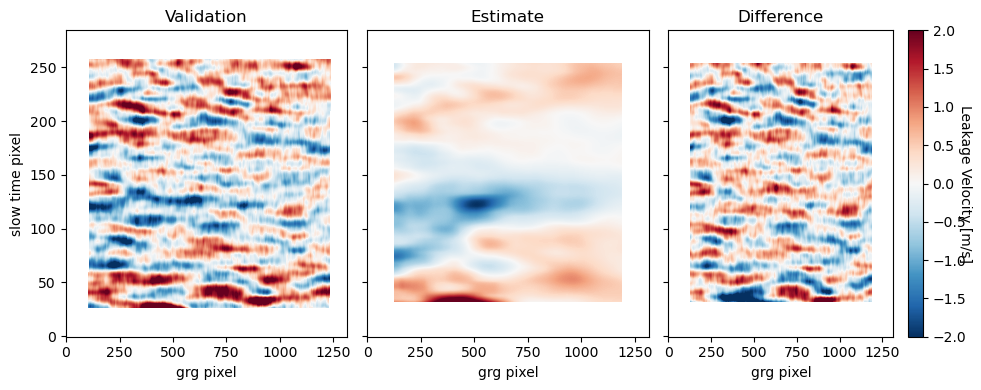

In [5]:
model_ML='/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/ML_analyses/Vleak_subscene_w_noise_n_20_5Tr_2Te_v1/stacked_model.joblib'

for scenario in scenarios_test:
   
   ds = prediction_ML(filename=scenario, model_ML=model_ML)

   plt.figure()
   ds.nrcs_scat_w_noise.T.plot(robust =True, vmin =0, cmap = 'Greys_r')

   ds['original'] = ds['V_leakage_pulse_rg_subscene'] - ds['V_leakage_pulse_rg_subscene_inverted']
   ds['difference'] = ds['original'] - ds['estimate']

   perf_ML = np.sqrt(np.nanmean(ds['difference']**2)), np.nanmedian(ds['difference'])
   perf_inv = np.sqrt(np.nanmean(ds['original']**2)), np.nanmedian(ds['original'])

   print(f"ML performance, RMSE: {perf_ML[0]:.3f} m/s, median error: {perf_ML[1]:.3f} m/s")
   print(f"Inversion performance, RMSE: {perf_inv[0]:.3f} m/s, median error: {perf_inv[1]:.3f} m/s")


   fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)

   vmin = -2;
   vmax = 2
   im0 = axes[0].imshow(ds.original.T, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu_r')
   im1 = axes[1].imshow(ds.estimate.T, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu_r')
   im2 = axes[2].imshow(ds.difference.T, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu_r')
   [ax.set_xlabel('grg pixel') for ax in axes]
   axes[0].set_ylabel('slow time pixel')
   axes[0].set_title('Validation')
   axes[1].set_title('Estimate')
   axes[2].set_title('Difference')
   cbar = plt.colorbar(im0, ax=axes[2])
   cbar.ax.set_ylabel('Leakage Velocity [m/s]', rotation=270)
   fig.tight_layout()

## - Frequency domain analysis

/Users/opodriscoll/miniconda3/envs/env_AutoML_xarray/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


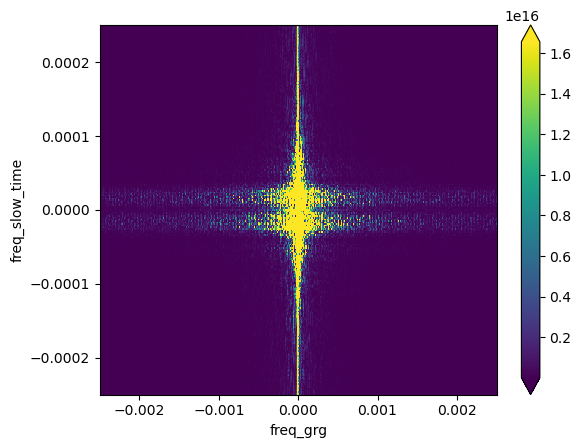

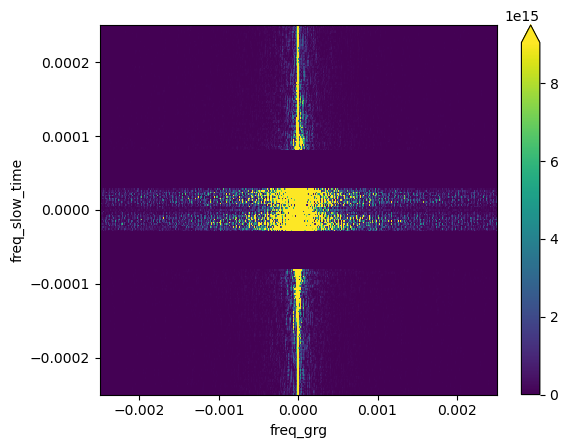

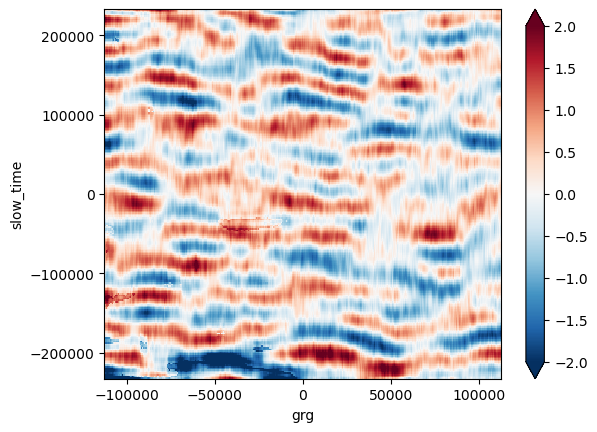

In [9]:
d4fft = ds.difference.dropna(dim ='slow_time', how = 'all').dropna(dim='grg')
d4fft = d4fft.assign_coords(
    {'slow_time':('slow_time',d4fft.slow_time.values - np.mean(d4fft.slow_time.values)),
    'grg':('grg',d4fft.grg.values - np.mean(d4fft.grg.values))}
    )

ps = xrft.fft(d4fft, window = 'boxcar')
ps_l = np.log10(ps)
plt.figure()
(abs(ps)**2).plot(robust = True)

condition = (abs(ps.freq_slow_time) < 8e-5) & (abs(ps.freq_slow_time) > 3e-5)

ps_f = xr.where(condition, 0,  ps)
plt.figure()
(abs(ps_f)**2).plot(robust = True)

inv = np.real(xrft.ifft(ps_f))
plt.figure()
inv.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r')

In [10]:
print(f"RMSE before and after removal of incorrect noise frequencies: {perf_ML[0]:.3f} m/s & {np.sqrt(np.nanmean(inv**2)):.3f} m/s")

RMSE before and after removal of incorrect noise frequencies: 0.810 m/s & 0.755 m/s


## t-SNE presentation

In [60]:
from sklearn.manifold import TSNE

scene = -1 # NOTE only works for the most recent scene as y_pred is the last scenario run
n_indexes = 10000
random_state = 42
X = X_test[scene].sample(n = n_indexes, random_state = random_state)
indexes = X.index.values
colour = (y_test[scene] - y_pred).loc[indexes]

# Create a t-SNE model with 2 components (for 2D visualization)
tsne = TSNE(n_components=2, random_state=random_state, perplexity=15)

# Fit and transform the data
X_tsne = tsne.fit_transform(X)

In [61]:
%matplotlib qt

fig, axes = plt.subplots(figsize=(6, 4))
vmax = np.percentile(abs(colour), 90)
im = axes.scatter(X_tsne[:, 0], X_tsne[:, 1], c = colour, picker=True, cmap ='PRGn',vmax = vmax, vmin = -abs(vmax) )

def to_dB(x):
    return 10*np.log10(x)

def on_pick(event):
    index = event.ind[0]

    plt.figure(figsize = (5.5,3.5))
    plt.plot(to_dB(X.iloc[index].values))
    plt.xlabel('index'); plt.ylabel('nrcs [dB]')
    plt.title(f'index: {index}')

fig.canvas.callbacks.connect('pick_event', on_pick)


cbar = plt.colorbar(im, ax=axes)
cbar.ax.set_ylabel('Leakage Velocity [m/s]', rotation=270, labelpad=10)


Text(0, 0.5, 'Leakage Velocity [m/s]')

In [62]:
%matplotlib qt
import mplcursors  # Import mplcursors library

fig, axes = plt.subplots(figsize=(6, 4))
vmax = np.percentile(abs(colour), 90)
im = axes.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colour, cmap='PRGn', vmax=vmax, vmin=-abs(vmax))

def to_dB(x):
    return 10 * np.log10(x)

first_hover_flag = [True] 

def on_hover(sel):
    index = sel.target.index
    if first_hover_flag[0]:
        first_hover_flag[0] = False
        global axes2
        fig2, axes2 = plt.subplots(figsize=(5.5, 3.5))
        
    axes2.clear()
    axes2.plot(to_dB(X.iloc[index].values))
    axes2.set_xlabel('index')
    axes2.set_ylabel('nrcs [dB]')
    axes2.set_title(f'index: {index}')
    plt.draw()

# Use mplcursors to connect the hover event
mplcursors.cursor(hover=True).connect("add", on_hover)

cbar = plt.colorbar(im, ax=axes)
cbar.ax.set_ylabel('Leakage Velocity [m/s]', rotation=270, labelpad=10)

plt.draw()


/Users/opodriscoll/miniconda3/envs/env_AutoML_xarray/lib/python3.9/site-packages/mplcursors/_pick_info.py:142: UserWarning: Selection.target.index is deprecated and will be removed in the future; use Selection.index instead.
  warnings.warn(


In [101]:
%matplotlib inline 